In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
col_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

## 1. read the uploaded excel

In [39]:
df = pd.concat(pd.read_excel('../data_gen_scripts/sales_data_latest_lite.xlsx', sheet_name=None), ignore_index=True)
df.head()

,Order ID,Product ID,Customer ID,Product,Brand,Sale Date,Unit Price,Quantity,Total Price,Special Day
0,OID-961886,PID-658902,CID-155790,Mechanical Keyboard,Acer,01/01/2017,2642.31,24,63415.44,True
1,OID-016601,PID-173762,CID-659090,Bluetooth Headset,Acer,01/01/2017,2442.55,7,17097.85,True
2,OID-130164,PID-633684,CID-707171,Gaming Mouse,Apple,01/01/2017,3684.98,21,77384.58,True
3,OID-682360,PID-712306,CID-879819,HiFi Headset,Acer,01/01/2017,3420.92,29,99206.68,True
4,OID-881191,PID-754891,CID-335827,Keyboard,Microsoft,01/02/2017,2050.90,23,47170.70,False


In [40]:
df = df.set_index('Sale Date')

In [41]:
df.index = pd.to_datetime(df.index)

/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/01/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/02/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/03/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/04/2017' in

In [42]:
## Just checking for a single product. 
df = df[df.Product == 'Monitor']
df.head()

,Order ID,Product ID,Customer ID,Product,Brand,Unit Price,Quantity,Total Price,Special Day
Sale Date,,,,,,,,,
2017-01-04,OID-332295,PID-034733,CID-219551,Monitor,Logitech,15647.35,26,406831.10,False
2017-01-04,OID-095806,PID-002819,CID-869922,Monitor,HP,13445.47,3,40336.41,False
2017-01-08,OID-399583,PID-239332,CID-379284,Monitor,BoAt,15892.58,21,333744.18,False
2017-02-02,OID-312451,PID-369410,CID-934800,Monitor,Lenovo,17892.39,17,304170.63,False
2017-02-05,OID-980497,PID-389449,CID-057384,Monitor,Logitech,12650.57,29,366866.53,False


<AxesSubplot:title={'center':'Initial data preview'}, xlabel='Sale Date'>

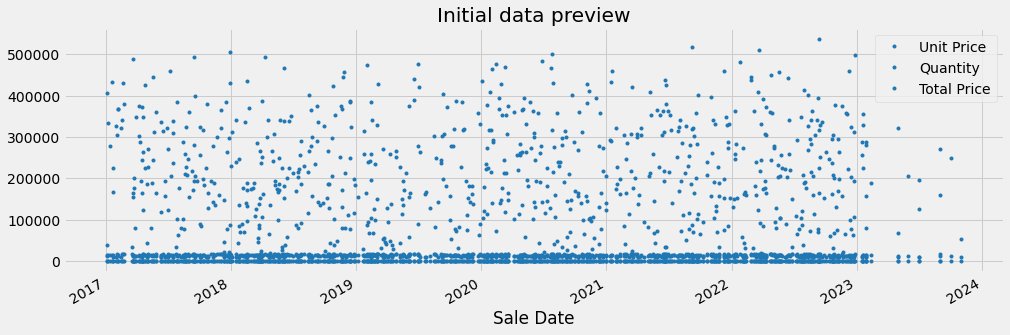

In [43]:
df.plot(style='.', figsize=(15,5), color=col_palette[0], title='Initial data preview')

## 2. Train Split

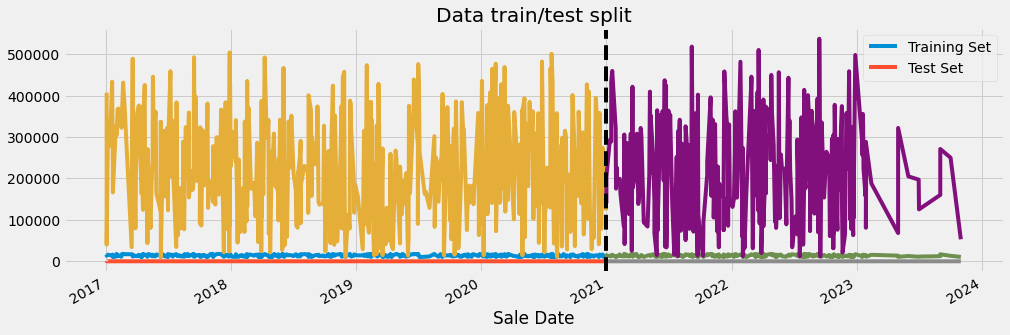

In [44]:

train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax =ax, label='Training Set', title='Data train/test split')
test.plot(ax= ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot:xlabel='Sale Date'>

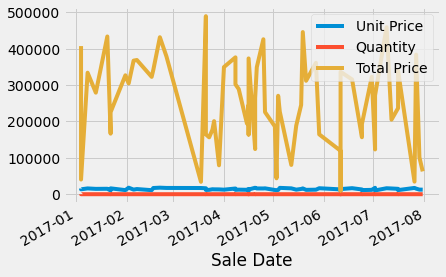

In [45]:
df.loc[(df.index > '01-01-2017') & (df.index < '08-01-2017')].plot()

## Feature Creation

In [46]:
def create_features(df):
    """
    Create time series features based on time series index 
    """
    df = df.copy()
    df['dayofweek']=df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear']  = df.index.day_of_year
    df['year'] = df.index.year
    return df
df = create_features(df)

In [37]:
df.columns

Index(['Order ID', 'Product ID', 'Customer ID', 'Product', 'Brand',
       'Sale Date', 'Unit Price', 'Quantity', 'Total Price', 'Special Day'],
      dtype='object')

## Visualize Feature / Target relationship

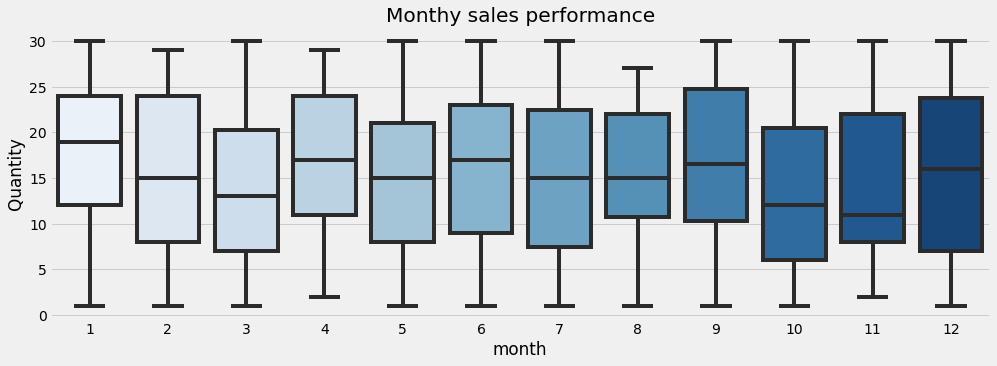

In [47]:

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='Quantity', palette = 'Blues')
ax.set_title('Monthy sales performance')
plt.show()

In [48]:
## creating features for training and testing datasets
train = create_features(train)
test = create_features(test)

# train['Special Day'] = pd.to_datetime(train['Special Day'], infer_datetime_format=True)
# test['Special Day'] = pd.to_datetime(test['Special Day'], infer_datetime_format=True)
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'year', 'Special Day']
TARGET = 'Quantity'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Model Creation 

In [49]:
reg = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds = 50)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train),(X_test, y_test)], 
        verbose=True)

[0]	validation_0-rmse:13.19848	validation_1-rmse:13.87894
[1]	validation_0-rmse:10.75989	validation_1-rmse:11.52486
[2]	validation_0-rmse:9.22431	validation_1-rmse:10.16249


[3]	validation_0-rmse:8.11738	validation_1-rmse:9.44668
[4]	validation_0-rmse:7.52664	validation_1-rmse:9.04480
[5]	validation_0-rmse:7.11469	validation_1-rmse:8.90541
[6]	validation_0-rmse:6.85460	validation_1-rmse:8.86044
[7]	validation_0-rmse:6.61188	validation_1-rmse:8.88029
[8]	validation_0-rmse:6.40984	validation_1-rmse:8.84687
[9]	validation_0-rmse:6.15128	validation_1-rmse:8.93891
[10]	validation_0-rmse:6.04923	validation_1-rmse:8.97945
[11]	validation_0-rmse:5.99455	validation_1-rmse:8.99629
[12]	validation_0-rmse:5.79558	validation_1-rmse:9.05723
[13]	validation_0-rmse:5.71843	validation_1-rmse:9.09640
[14]	validation_0-rmse:5.58086	validation_1-rmse:9.15755
[15]	validation_0-rmse:5.47108	validation_1-rmse:9.26307
[16]	validation_0-rmse:5.40997	validation_1-rmse:9.30004
[17]	validation_0-rmse:5.25823	validation_1-rmse:9.31532
[18]	validation_0-rmse:5.20497	validation_1-rmse:9.36955
[19]	validation_0-rmse:5.11534	validation_1-rmse:9.43063
[20]	validation_0-rmse:5.07539	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature importances for selection

<AxesSubplot:title={'center':'Feature importance'}>

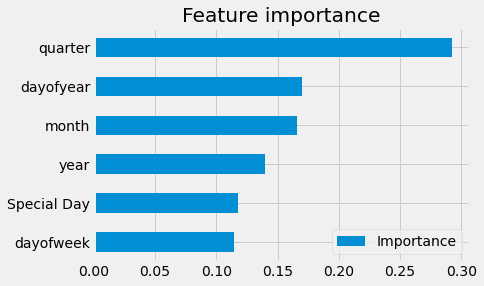

In [50]:
fi = pd.DataFrame(data = reg.feature_importances_, 
             index = reg.feature_names_in_,
             columns = ['Importance'])
fi.sort_values('Importance').plot(kind= 'barh', title='Feature importance')

## Forecasting...

In [51]:
test['Prediction'] = reg.predict(X_test)

In [52]:
df = df.merge(test['Prediction'], how='left', left_index=True, right_index=True)

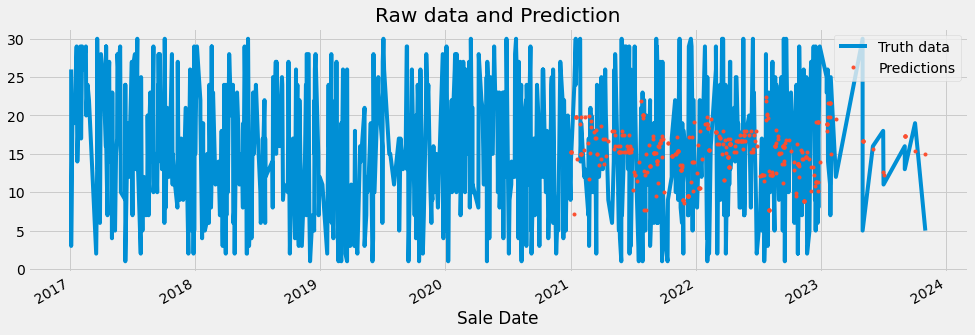

In [53]:
ax = df[['Quantity']].plot(figsize=(15,5))
df['Prediction'].plot(ax = ax, style='.')
plt.legend(['Truth data', 'Predictions'])
ax.set_title('Raw data and Prediction')
plt.show()

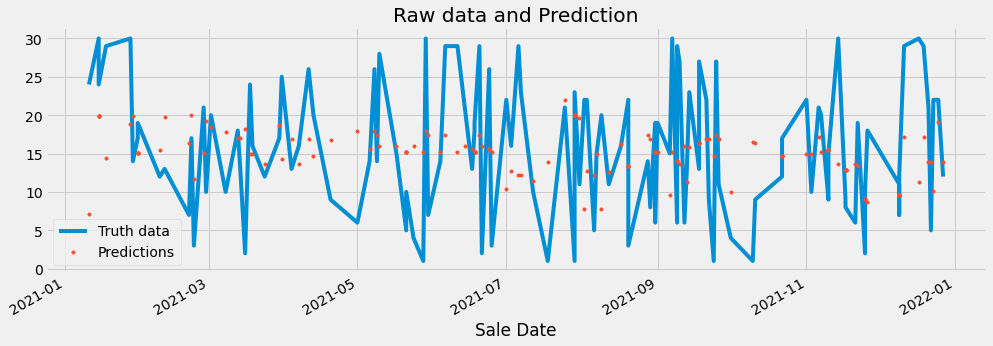

In [54]:
ax = df.loc[(df.index > '01-01-2021') & (df.index < '01-01-2022')]['Quantity'].plot(figsize=(15,5), title='week data')
df.loc[(df.index > '01-01-2021') & (df.index < '01-01-2022')]['Prediction'].plot(style='.')
plt.legend(['Truth data', 'Predictions'])
ax.set_title('Raw data and Prediction')
plt.show()


In [55]:
# Saving the model to disk
# reg.save_model('xg_model_v2.json')

In [56]:
# to see the size of the model on the disk
# !ls -lh

In [57]:
# To load the trained model from local..
reg_v2 = xgb.XGBRFRegressor()
reg_v2.load_model('xg_model_v2.json')
